# GDC document: [Copy Number Variation Analysis](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/CNV_Pipeline/#copy-number-variation-analysis-pipeline)

The copy number variation (CNV) pipeline uses Affymetrix SNP 6.0 array data to identify genomic regions that are repeated and infer the copy number of these repeats. This pipeline is built onto the existing TCGA level 2 data generated by Birdsuite and uses the 
* DNAcopy R-package to perform a circular binary segmentation (CBS) analysis. 
    * CBS translates noisy intensity measurements into chromosomal regions of equal copy number. 
* The final output files are segmented into genomic regions with the estimated copy number for each region. 
* The GDC further transforms these copy number values into segment mean values, which are equal to *log2(copy-number/2)*. 
    * *Diploid regions* will have a *segment mean of zero*, 
    * *Amplified regions* will have *positive values*, and 
    * *Deletions: will have *negative values
* Threshold used in the copy number estimation was selected based on gdac.broadinstitute.org_*-TM.CopyNumber_Gistic2.Level_4 input parameters


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
sys.path.append("/Users/pubudu/Documents/MyGithub/my_modules/")
import ecdf, ffind

/Users/pubudu/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
c_ID = "SKCM"

In [3]:
segments_f = ffind.find("{}.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt".format(c_ID), "TCGA_datasets")
if len(segments_f) == 1:
    segments_f = segments_f[0]
else:
    print ("Error... check: TCGA_datasets")

segments_f_qcPassed = "datasets_0119/{}.qc_passed.txt".format(segments_f.split("/")[-1])
segments_f_qcPassed_bed = "datasets_0119/{}.qc_passed.bed".format(segments_f.split("/")[-1])
segments_f_gaia_in =  "datasets_0119/{}.GAIA_input_0119.txt".format(segments_f.split("/")[-1])
print(f'''
Segment file:
\t{segments_f}
    
QC passed files:
\t{segments_f_qcPassed}\n\t{segments_f_qcPassed_bed}
GAIA input file
\t{segments_f_gaia_in}
''')


Segment file:
	/Users/pubudu/Documents/SCAN-hic/V04-012019/01.SKCM/TCGA_datasets/gdac.broadinstitute.org_SKCM.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/SKCM.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt
    
QC passed files:
	datasets_0119/SKCM.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt.qc_passed.txt
	datasets_0119/SKCM.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt.qc_passed.bed
GAIA input file
	datasets_0119/SKCM.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt.GAIA_input_0119.txt



In [4]:
!mkdir datasets_0119

mkdir: datasets_0119: File exists


In [5]:
seg_file = pd.read_table("{}".format(segments_f))
seg_file.head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
0,TCGA-3N-A9WB-10A-01D-A38I-01,1,3218610,247813706,129090,0.0002
1,TCGA-3N-A9WB-10A-01D-A38I-01,2,484222,220577888,117921,0.0070
2,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733
3,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579399,229029654,5571,0.0021
4,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,-1.4593


In [6]:
len(seg_file[seg_file['Start']==seg_file['End']])

12

In [7]:
seg_file = seg_file[seg_file['Start']!=seg_file['End']].reset_index(drop=True)

In [8]:
input_file_len = len(seg_file)
print (input_file_len)

108072


In [9]:
print ("segments with nutral copy number:", len(seg_file[seg_file['Segment_Mean']==0]))

segments with nutral copy number: 239


In [10]:
seg_file = seg_file[seg_file['Segment_Mean']!=0]

In [11]:
len(seg_file)

107833

In [12]:
seg_file[(seg_file['Segment_Mean']<=-0.1) | (seg_file['Segment_Mean']>=0.1)].head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
2,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733
4,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,-1.4593
7,TCGA-3N-A9WB-10A-01D-A38I-01,3,126142163,126143025,3,-1.4494
9,TCGA-3N-A9WB-10A-01D-A38I-01,3,194767840,194768773,2,-1.5726
15,TCGA-3N-A9WB-10A-01D-A38I-01,7,80906520,80938113,20,-0.5794


In [13]:
len(seg_file[(seg_file['Segment_Mean']<=-0.1) | (seg_file['Segment_Mean']>=0.1)])

70660

In [14]:
seg_file = seg_file[(seg_file['Segment_Mean']<=-0.1) | (seg_file['Segment_Mean']>=0.1)].reset_index(drop=True)
seg_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70660 entries, 0 to 70659
Data columns (total 6 columns):
Sample          70660 non-null object
Chromosome      70660 non-null int64
Start           70660 non-null int64
End             70660 non-null int64
Num_Probes      70660 non-null int64
Segment_Mean    70660 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.2+ MB


In [15]:
type(seg_file.groupby(by='Sample').size())

pandas.core.series.Series

In [16]:
seg_file.groupby(by='Sample').size().apply(np.log10).head().tolist()

[1.7403626894942439,
 0.9030899869919435,
 2.0293837776852097,
 1.3010299956639813,
 1.662757831681574]

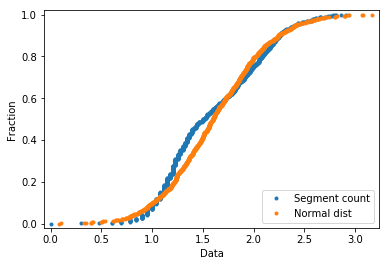

In [17]:
sample_counts = np.array(seg_file.groupby(by='Sample').size().apply(np.log10).tolist())
x,y = ecdf.ecdf(sample_counts)
x_norm, y_norm = ecdf.ecdf(np.random.normal(np.mean(sample_counts), np.std(sample_counts), len(sample_counts)))
plt.plot(x, y, marker = '.', linestyle = 'none')
plt.plot(x_norm, y_norm, marker = '.', linestyle = 'none')


# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel('Data')
plt.ylabel('Fraction')
plt.legend(('Segment count', 'Normal dist'), loc='lower right')

# Display the plot
plt.show()

In [18]:
seg_file_sample_counts = seg_file[['Sample','Chromosome']].groupby(by='Sample').count().rename(columns={'Chromosome':'Sample_count'})
seg_file_sample_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 937 entries, TCGA-3N-A9WB-06A-11D-A38F-01 to TCGA-Z2-AA3V-10A-01D-A399-01
Data columns (total 1 columns):
Sample_count    937 non-null int64
dtypes: int64(1)
memory usage: 14.6+ KB


In [19]:
seg_file_sample_counts.head()

,Sample_count
Sample,
TCGA-3N-A9WB-06A-11D-A38F-01,55
TCGA-3N-A9WB-10A-01D-A38I-01,8
TCGA-3N-A9WC-06A-11D-A38F-01,107
TCGA-3N-A9WC-10A-01D-A38I-01,20
TCGA-3N-A9WD-06A-11D-A38F-01,46


In [20]:
seg_file.loc[:10].apply(lambda x: seg_file_sample_counts.loc[x['Sample']], axis=1)

,Sample_count
0,8
1,8
2,8
3,8
4,8
5,8
6,8
7,8
8,55
9,55


In [21]:
seg_file['Seg_count'] = seg_file.apply(lambda x: seg_file_sample_counts.loc[x['Sample']], axis=1)

In [22]:
seg_file.head(10)

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,Seg_count
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733,8
1,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,-1.4593,8
2,TCGA-3N-A9WB-10A-01D-A38I-01,3,126142163,126143025,3,-1.4494,8
3,TCGA-3N-A9WB-10A-01D-A38I-01,3,194767840,194768773,2,-1.5726,8
4,TCGA-3N-A9WB-10A-01D-A38I-01,7,80906520,80938113,20,-0.5794,8
5,TCGA-3N-A9WB-10A-01D-A38I-01,12,69978623,69978626,2,-1.8934,8
6,TCGA-3N-A9WB-10A-01D-A38I-01,18,35839365,35839739,2,-1.6357,8
7,TCGA-3N-A9WB-10A-01D-A38I-01,21,20128348,20134730,5,-1.1037,8
8,TCGA-3N-A9WB-06A-11D-A38F-01,1,36475406,36477996,2,-1.7382,55
9,TCGA-3N-A9WB-06A-11D-A38F-01,1,85980350,86002735,10,0.4640,55


In [23]:
seg_file.drop_duplicates('Seg_count').head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,Seg_count
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733,8
8,TCGA-3N-A9WB-06A-11D-A38F-01,1,36475406,36477996,2,-1.7382,55
63,TCGA-3N-A9WC-10A-01D-A38I-01,1,180750573,180753483,4,-1.3170,20
83,TCGA-3N-A9WC-06A-11D-A38F-01,1,9526979,31621427,11170,0.3887,107
210,TCGA-3N-A9WD-06A-11D-A38F-01,1,3218610,163292362,75193,0.1018,46


In [24]:
seg_file.drop_duplicates('Sample').head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,Seg_count
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733,8
8,TCGA-3N-A9WB-06A-11D-A38F-01,1,36475406,36477996,2,-1.7382,55
63,TCGA-3N-A9WC-10A-01D-A38I-01,1,180750573,180753483,4,-1.3170,20
83,TCGA-3N-A9WC-06A-11D-A38F-01,1,9526979,31621427,11170,0.3887,107
190,TCGA-3N-A9WD-10A-01D-A38I-01,5,6759714,6760020,2,-1.1310,20


Text(0,0.5,'Cumulative distribution')

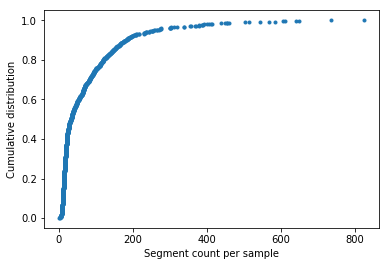

In [25]:
x,y = ecdf.ecdf(seg_file.drop_duplicates('Sample')['Seg_count'].values)
plt.plot(x,y,marker='.',linestyle='none')
plt.xlabel("Segment count per sample")
plt.ylabel("Cumulative distribution")

## Quality control steps (to reduce the effects from hyper-segmentation )
* Exclude hyper-segmentated samples

### 1. Exclude hyper-segmentated samples

** A. Calculate the number of segments in each sample** <br>
** B. Filter samples using pre-defined threshold on segment counts inorder to reduce the effects from hyper-segmentation (SegmentationCount)**

Step 8 - [Affymetrix SNP6 Copy Number Inference Pipeline](http://software.broadinstitute.org/cancer/software/genepattern/affymetrix-snp6-copy-number-inference-pipeline)

Noisy samples exhibit hyper-segmentation, where CBS calls a huge number of segments that is unlikely to reflect the underlying biology.  This QC metric counts the total number of segments in the genome, and compares it to a threshold.  This threshold is set by examining a q-q plot of its log and identifying the knee, which distinguishes the tail from the main distribution.

In [26]:
# s = np.array(seg_file.groupby(by='Sample').size().sort_values().tolist())
# fig = sm.qqplot(s, line='r')

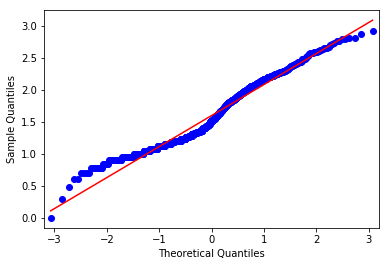

In [27]:
s_log = np.array(np.array(seg_file.groupby(by='Sample').size().apply(np.log10).sort_values().tolist()))
fig = sm.qqplot(s_log, line='r')

#### SegmentationCount Documentation

Description: Counts the number of segments in a SEG file. Author: Gordon Saksena, gp-help@broadinstitute.org

**Summary**
* Counts the number of segments in the segmentation file, compares this count to a quality threshold cutoff of 2000, and outputs this information in a file. The threshold value of 2000 was selected based on looking at the distribution of data from 10,000+ samples, and selecting a bound between the main distribution and its outliers. The segmentation count is a way of measuring hyper-segmentation. Typical samples should contain hundreds of segments; if the seg file claims that it contains 10’s of thousands, this is unlikely to reflect the underlying biology.

In [28]:
Seg_count_thresh = 2000
#probeThresh = 25
#seg_file = seg_file[(seg_file['Seg_count']<Seg_count_thresh) & (seg_file['Num_Probes']>=probeThresh)].reset_index(drop=True)
seg_file = seg_file[(seg_file['Seg_count']<Seg_count_thresh)].reset_index(drop=True)
print ("Number of CNVs after filtering hyper-segmented samples:", len(seg_file[seg_file['Seg_count']<Seg_count_thresh]))

Number of CNVs after filtering hyper-segmented samples: 70660


In [29]:
seg_file_qc = seg_file
seg_file_qc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70660 entries, 0 to 70659
Data columns (total 7 columns):
Sample          70660 non-null object
Chromosome      70660 non-null int64
Start           70660 non-null int64
End             70660 non-null int64
Num_Probes      70660 non-null int64
Segment_Mean    70660 non-null float64
Seg_count       70660 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 3.8+ MB


In [30]:
print (f"Percentage of filtered-out segments: {np.around((input_file_len-len(seg_file_qc))/input_file_len*100, 2)}%")

Percentage of filtered-out segments: 34.62%


In [31]:
seg_file_qc.head()

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,Seg_count
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733,8
1,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,-1.4593,8
2,TCGA-3N-A9WB-10A-01D-A38I-01,3,126142163,126143025,3,-1.4494,8
3,TCGA-3N-A9WB-10A-01D-A38I-01,3,194767840,194768773,2,-1.5726,8
4,TCGA-3N-A9WB-10A-01D-A38I-01,7,80906520,80938113,20,-0.5794,8


In [32]:
seg_file_qc.to_csv(segments_f_qcPassed, sep="\t", index=False, header=True)

In [33]:
Seg_len  = seg_file_qc.apply(lambda x: (x['End'] - x['Start'])/1000.0, axis=1)
Seg_len .describe()

count     70660.000000
mean       9949.669360
std       24926.473655
min           0.001000
25%           4.804750
50%         186.599500
75%        4856.525250
max      244595.096000
dtype: float64

Text(0.5,0,'Segment length (in kb)')

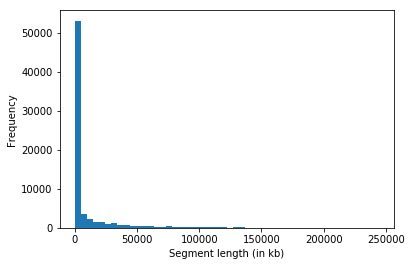

In [34]:
Seg_len .plot(kind='hist', bins=50)
plt.xlabel('Segment length (in kb)')

Text(0,0.5,'Fraction')

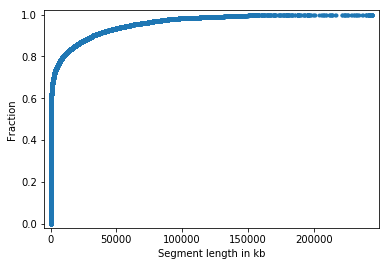

In [35]:
x,y = ecdf.ecdf(Seg_len.values )
plt.plot(x, y, marker = '.', linestyle = 'none')

# Make the margins nice
plt.margins(0.02)

# Label the axes
plt.xlabel('Segment length in kb')
plt.ylabel('Fraction')

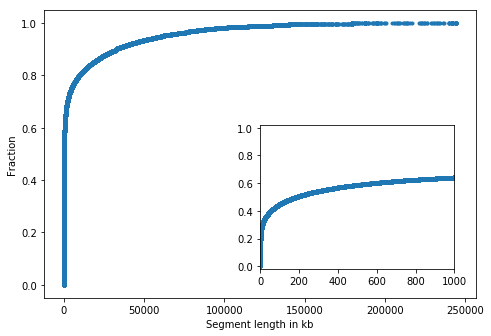

In [36]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([0.5, 0.1, 0.45, 0.5])

ax1.plot(x, y, marker = '.', linestyle = 'none')
ax1.set_xlabel('Segment length in kb')
ax1.set_ylabel('Fraction')

ax2.plot(x, y, marker = '.', linestyle = 'none')
ax2.set_xlim(0,1000)

# Make the margins nice
plt.margins(0.02)



### Creating [GAIA input](http://bioconductor.org/packages/release/bioc/vignettes/gaia/inst/doc/gaia.pdf) 

4.2 Aberrant Region Descriptor Matrix
This matrix contains all needed informations about the observed aberrant regions.This matrix has a row for each aberrant region and each of them is described by the following columns:
1. Sample Name : The name of the sample in which the aberrant region is observed;
1. Chromosome : The chromosome where the aberrant region is located;
1. Start : The genomic position (in bp) where the aberrant region starts;
1. End : The genomic position (in bp) where the aberrant region ends;
1. Num of Markers : The number of markers contained in the aberrant region;
1. Aberration : An integer indicating the kind of the mutation.

The column Aberration can assume only integer values in the range 0, · · · , K −1 where K is the number of considered aberrations. 
For example if we are considering loss, LOH and gain mutations than the only valid values for the column Aberration are 0, 1 and 2

In [37]:
len(seg_file_qc[seg_file_qc['Segment_Mean']==0])

0

In [38]:
## The copy number variation (CNV) pipeline uses Affymetrix SNP 6.0 array data to identify genomic regions that are repeated and infer the copy number of these repeats. 
## This pipeline is built onto the existing TCGA level 2 data generated by Birdsuite and uses the DNAcopy R-package to perform a circular binary segmentation (CBS) analysis  
## CBS translates noisy intensity measurements into chromosomal regions of equal copy number. 
## The final output files are segmented into genomic regions with the estimated copy number for each region. 
## The GDC further transforms these copy number values into segment mean values, which are equal to log2(copy-number/ 2). 
##                    Diploid regions will have a segment mean of zero, 
##                    amplified regions will have positive values, and 
##                    deletions will have negative values.
### Ref: https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/CNV_Pipeline/#copy-number-variation-analysis-pipeline
## List of inputs used for this Broad GISTIC2 run - gdac.broadinstitute.org_SKCM-TM.CopyNumber_Gistic2.Level_4.2016012800.0.0
#### Amplification Threshold = 0.1
#### Deletion Threshold = 0.1

### GAIA Aberration column should contain only 0 and 1 when considering deletions and duplications (0 for loss, 1 for gain)

def cns_check(Segment_Mean):
    if Segment_Mean<= -0.1:
        return (0, "DEL")
    elif Segment_Mean>= 0.1:
        return (1, "AMP")
    else:
        print ("Error...")

In [39]:
seg_file_qc['Aberration'], seg_file_qc['CNS'] = zip(*seg_file_qc['Segment_Mean'].apply(lambda x: cns_check(x)))
seg_file_qc.head(20)

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,Seg_count,Aberration,CNS
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,-1.6733,8,0,DEL
1,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,-1.4593,8,0,DEL
2,TCGA-3N-A9WB-10A-01D-A38I-01,3,126142163,126143025,3,-1.4494,8,0,DEL
3,TCGA-3N-A9WB-10A-01D-A38I-01,3,194767840,194768773,2,-1.5726,8,0,DEL
4,TCGA-3N-A9WB-10A-01D-A38I-01,7,80906520,80938113,20,-0.5794,8,0,DEL
5,TCGA-3N-A9WB-10A-01D-A38I-01,12,69978623,69978626,2,-1.8934,8,0,DEL
6,TCGA-3N-A9WB-10A-01D-A38I-01,18,35839365,35839739,2,-1.6357,8,0,DEL
7,TCGA-3N-A9WB-10A-01D-A38I-01,21,20128348,20134730,5,-1.1037,8,0,DEL
8,TCGA-3N-A9WB-06A-11D-A38F-01,1,36475406,36477996,2,-1.7382,55,0,DEL
9,TCGA-3N-A9WB-06A-11D-A38F-01,1,85980350,86002735,10,0.4640,55,1,AMP


In [40]:
print (len(seg_file_qc))
print (len(seg_file_qc[~seg_file_qc['Aberration'].isna()]))

70660
70660


In [41]:
seg_file_qc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70660 entries, 0 to 70659
Data columns (total 9 columns):
Sample          70660 non-null object
Chromosome      70660 non-null int64
Start           70660 non-null int64
End             70660 non-null int64
Num_Probes      70660 non-null int64
Segment_Mean    70660 non-null float64
Seg_count       70660 non-null int64
Aberration      70660 non-null int64
CNS             70660 non-null object
dtypes: float64(1), int64(6), object(2)
memory usage: 4.9+ MB


In [42]:
seg_file_qc[["Chromosome", "Start", "End", "CNS", "Segment_Mean", "Sample"]].rename(columns={"Chromosome":"#Chromosome"}).to_csv(segments_f_qcPassed_bed, sep="\t", index=False, header=True)

In [43]:
seg_file_qc = seg_file_qc.drop(labels=['Seg_count', 'Segment_Mean', "CNS"], axis=1)
seg_file_qc.head()

,Sample,Chromosome,Start,End,Num_Probes,Aberration
0,TCGA-3N-A9WB-10A-01D-A38I-01,2,220579272,220579384,2,0
1,TCGA-3N-A9WB-10A-01D-A38I-01,2,229030300,229031430,3,0
2,TCGA-3N-A9WB-10A-01D-A38I-01,3,126142163,126143025,3,0
3,TCGA-3N-A9WB-10A-01D-A38I-01,3,194767840,194768773,2,0
4,TCGA-3N-A9WB-10A-01D-A38I-01,7,80906520,80938113,20,0


In [44]:
seg_file_qc.to_csv(segments_f_gaia_in, sep="\t", index=False, header=True)

In [45]:
f_out = open("{}_breakpoints.bed".format(segments_f_qcPassed_bed), "w")

with open(segments_f_qcPassed_bed, 'r') as f:
    for i in range(10):
        f.readline()
        for line in f:
            cns = ""
            line = line.replace("\n", "").split("\t")
            f_out.write("chr{}\t{}\t{}\t{}\t{}\nchr{}\t{}\t{}\t{}\t{}\n".format(line[0], line[1], int(line[1])+1, line[3], line[5], line[0], line[2], int(line[2])+1, line[3], line[5]) )
f_out.close()

In [46]:
seg_file_qc.groupby('Aberration').size()

Aberration
0    39634
1    31026
dtype: int64